In [1]:
import sys
sys.path.append('../../../src')
from helpers import *
import matplotlib.transforms as transforms
%matplotlib notebook

if not os.path.exists('Figs'):
    os.mkdir('Figs')

### Quantification

In [2]:
df = pd.read_csv('../../Raw analysis/PAR-2 NEBD quantification/NEBD_Embryos_dataframe.csv')
df_quantification = pd.read_csv('../../Raw analysis/PAR-2 NEBD quantification/QUANTIFICATION.csv')
df_quantification_grouped = df_quantification.groupby('EmbryoID')

df_summary = pd.DataFrame()
for i, r in df_quantification_grouped:
    cyt = np.mean(r['Cytoplasmic signal'])
    mem_tot = np.mean(r['Membrane signal'])
    mem_ant = bounded_mean_1d(r['Membrane signal'], [0.4, 0.6])
    mem_post = bounded_mean_1d(r['Membrane signal'], [0.9, 0.1]) 
    ratio_post = mem_post / cyt
    p = {'EmbryoID': i, 'Cyt': cyt, 'Mem_tot': mem_tot, 'Mem_ant': mem_ant, 'Mem_post': mem_post,
        'Ratio post': ratio_post} 
    df_summary = df_summary.append(pd.DataFrame(p, index=[i]))
df = pd.merge(df, df_summary, on='EmbryoID')

# Filter
df = df[df.Line.isin(['lp637', 'nwg201', 'nwg240', 'nwg246', 'nwg338', 'nwg369'])]

# Add uniform vs polarised column
unipol = ['Pol' if x in ['lp637', 'nwg240', 'nwg338'] else 'Uni' for x in df.Line]
df['UniPol'] = unipol

# Add genotype column
genotype = ['WT' if x in ['lp637', 'nwg201'] else 'C56S' if x in ['nwg240', 'nwg246'] else 'L109R' for x in df.Line]
df['Genotype'] = genotype

### WT vs C566S

In [3]:
def dataplot(data, x, y, ax, order, width=0.4, linewidth=1, transform=None, offset=0, color=None, jitter=0.05, 
             hue=None, palette=None):
    df_mean = [data[data[x] == o][y].mean() for o in order]
    [ax.hlines(y, i + offset - width/2, i + offset + width/2, zorder=100, color='k', 
               linewidth=1) for i, y in enumerate(df_mean)]
    sns.swarmplot(data=data, x=x, y=y, ax=ax, order=order, linewidth=linewidth, transform=transform, color=color,
                  hue=hue, palette=palette)

<IPython.core.display.Javascript object>


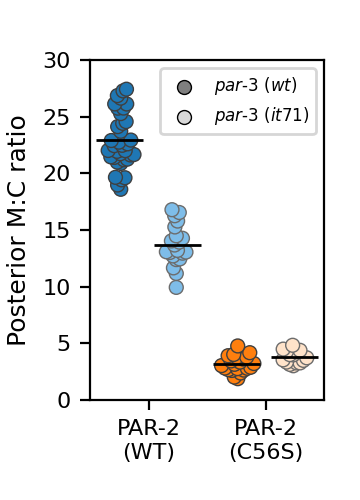

In [4]:
_df = df[df.Line.isin(['lp637', 'nwg201', 'nwg240', 'nwg246'])]

palette1 = {'WT':'tab:blue', 'C56S':'tab:orange'}
palette2 = {_: lighten(__, 1.7) for _, __ in palette1.items()}
order = ['WT', 'C56S']

fig, ax = plt.subplots()
fig.set_size_inches(7, 2.5)
offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

dot1 = ax.scatter(x=[], y=[], linewidth=0.5, edgecolors='k', color='tab:gray', s=25)
dot2 = ax.scatter(x=[], y=[], linewidth=0.5, edgecolors='k', color=lighten('tab:gray', 1.7), s=25)

dataplot(data=_df[(_df.RNAi == 'wt') * (_df.UniPol == 'Pol')], x='Genotype', y='Ratio post', 
              ax=ax, order=order, hue='Genotype', palette=palette1,
              transform=trans+offset(-10), jitter=0.02, linewidth=0.5, offset=-0.25)
dataplot(data=_df[(_df.RNAi == 'wt') * (_df.UniPol == 'Uni')], x='Genotype', y='Ratio post', 
              ax=ax, order=order, hue='Genotype', palette=palette2,
              transform=trans+offset(10), jitter=0.02, linewidth=0.5, offset=0.25)

ax.legend([dot1, dot2], [r'$par$' +'-' + r'$3\ (wt)$', r'$par$' +'-' + r'$3\ (it71)$'], fontsize=6)

ax.set_xticklabels(['PAR-2\n(WT)', 'PAR-2\n(C56S)'])
# for tick in ax.get_xticklabels():
#     tick.set_rotation(45)
#     tick.set_horizontalalignment('right')
ax.tick_params(axis='both', labelsize=8)
ax.set_xlabel('')
ax.set_ylim(0, 30)
ax.set_ylabel('Posterior M:C ratio', fontsize=9)
fig.set_size_inches(1.8, 2.5)
fig.subplots_adjust(left=0.25, bottom=0.2)
fig.savefig('Figs/mc_ratio.png', dpi=600, transparent=True)

### Images - WT vs C56S

<IPython.core.display.Javascript object>


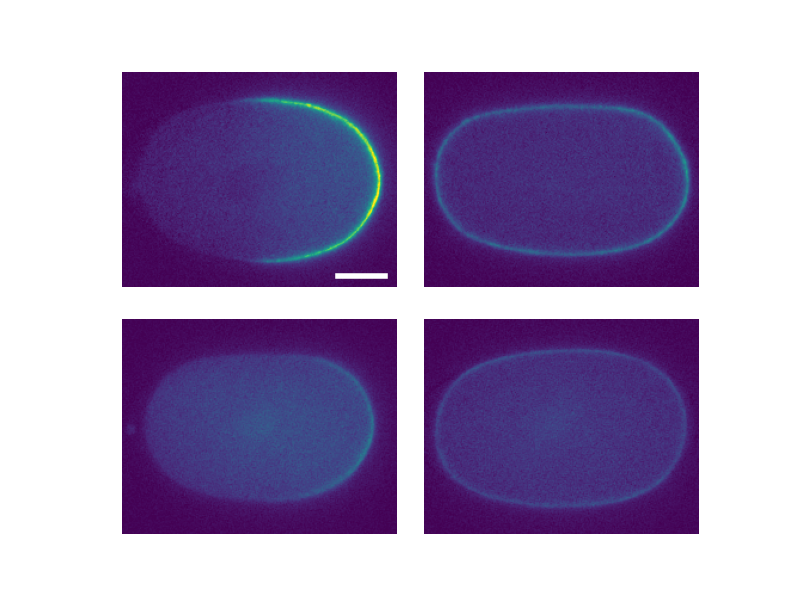

In [5]:
def func(ax, path, scale_bar=False):
    img = load_image(path + '/af_corrected.tif')
    roi = np.loadtxt(path + '/ROI_fit.txt')
    rotated = rotated_embryo(img, roi, 230, 180, 3)
    ax.imshow(rotated, cmap='viridis', vmin=0, vmax=35000)
    ax.axis('off')
    
    if scale_bar:
        px = 0.255 # pixel size
        bar_length = 10  # microns
        bar_pixels = bar_length / px
        y = rotated.shape[0] - 10
        ax.plot([rotated.shape[1]-10-bar_pixels, rotated.shape[1]-10], [y, y], color='w', linewidth=2)

fig, ax = plt.subplots(2,2)
func(ax[0][0], df[(df.RNAi == 'wt') * (df.Genotype == 'WT') * (df.UniPol == 'Pol')].Path.iloc[0], scale_bar=True)
func(ax[0][1], df[(df.RNAi == 'wt') * (df.Genotype == 'WT') * (df.UniPol == 'Uni')].Path.iloc[1])
func(ax[1][0], df[(df.RNAi == 'wt') * (df.Genotype == 'C56S') * (df.UniPol == 'Pol')].Path.iloc[0])
func(ax[1][1], df[(df.RNAi == 'wt') * (df.Genotype == 'C56S') * (df.UniPol == 'Uni')].Path.iloc[0])
fig.set_size_inches(4, 3)
fig.subplots_adjust(wspace=-0.05, hspace=0.15)
fig.savefig('Figs/embryos.png', dpi=600, transparent=True)

### WT vs L109R

<IPython.core.display.Javascript object>


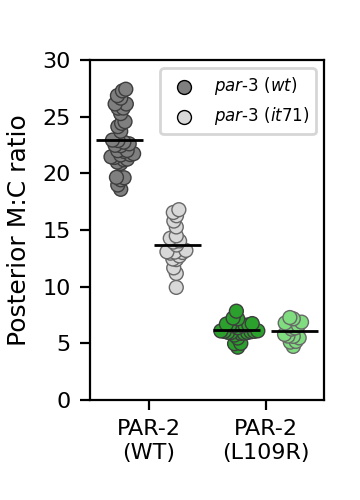

In [6]:
_df = df[df.Line.isin(['lp637', 'nwg201', 'nwg338', 'nwg369'])]

palette1 = {'WT':'tab:gray', 'L109R':'tab:green'}
palette2 = {_: lighten(__, 1.7) for _, __ in palette1.items()}
order = ['WT', 'L109R']

fig, ax = plt.subplots()
fig.set_size_inches(7, 2.5)
offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

dot1 = ax.scatter(x=[], y=[], linewidth=0.5, edgecolors='k', color='tab:gray', s=25)
dot2 = ax.scatter(x=[], y=[], linewidth=0.5, edgecolors='k', color=lighten('tab:gray', 1.7), s=25)

dataplot(data=_df[(_df.RNAi == 'wt') * (_df.UniPol == 'Pol')], x='Genotype', y='Ratio post', 
              ax=ax, order=order, hue='Genotype', palette=palette1,
              transform=trans+offset(-10), jitter=0.02, linewidth=0.5, offset=-0.25)
dataplot(data=_df[(_df.RNAi == 'wt') * (_df.UniPol == 'Uni')], x='Genotype', y='Ratio post', 
              ax=ax, order=order, hue='Genotype', palette=palette2,
              transform=trans+offset(10), jitter=0.02, linewidth=0.5, offset=0.25)

ax.legend([dot1, dot2], [r'$par$' +'-' + r'$3\ (wt)$', r'$par$' +'-' + r'$3\ (it71)$'], fontsize=6)

ax.set_xticklabels(['PAR-2\n(WT)', 'PAR-2\n(L109R)'])
ax.tick_params(axis='both', labelsize=8)
ax.set_xlabel('')
ax.set_ylim(0, 30)
ax.set_ylabel('Posterior M:C ratio', fontsize=9)
fig.set_size_inches(1.8, 2.5)
fig.subplots_adjust(left=0.25, bottom=0.2)
fig.savefig('Figs/mc_ratio_l109r.png', dpi=600, transparent=True)